In [1]:
import torch
from torch import nn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
sys.path.append('./transformer')
from utils import SignalDataset_music
import argparse
from transformer.model_crnn import TransformerModel as TransformerModel1
from transformer.model_concat import TransformerModel as TransformerModel2
import torch.optim as optim
import numpy as np
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import os
import time
import random
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
np.random.seed(1111)
random.seed(1111)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_cuda = True

In [3]:
"""
Data Loading
"""
torch.set_default_tensor_type('torch.FloatTensor')
print("Start loading the data....")
test_set = SignalDataset_music('music/', 64, train=False)
print("Finish loading the data....")
loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

Start loading the data....
Finish loading the data....


In [4]:
model1 = TransformerModel1(time_step=64,
                         input_dims=[2048, 2048],
                         hidden_size=2048,
                         embed_dim=320,
                         output_dim=128,
                         out_dropout=0.5)
if use_cuda and torch.cuda.is_available():
    model1 = model1.cuda()
    
if os.path.isfile('model/crnn.pt'):
    checkpoint1 = torch.load('model/crnn.pt')
    model1.load_state_dict(checkpoint1['model_state_dict'])

In [6]:
model2 = TransformerModel2(time_step=64,
                             input_dims=[2048, 2048],
                             hidden_size=2048,
                             embed_dim=320,
                             output_dim=128,
                             num_heads=8,
                             attn_dropout=0.0,
                             relu_dropout=0.1,
                             res_dropout=0.1,
                             out_dropout=0.5,
                             layers=6,
                             attn_mask=False)
if use_cuda and torch.cuda.is_available():
    model2 = model2.cuda()
    
if os.path.isfile('model/concat.pt'):
    checkpoint2 = torch.load('model/concat.pt')
    model2.load_state_dict(checkpoint2['model_state_dict'])

Encoder Model size: 3709440


In [14]:
batch_size = 16
total_batch_size = 0
shape = (64, test_set.len, 128)
true_vals1 = torch.zeros(shape)
pred_vals1 = torch.zeros(shape)
model1.eval()
with torch.no_grad():
    for i_batch, (batch_X, batch_y) in enumerate(loader):
        batch_X = batch_X.transpose(0, 1)
        batch_y = batch_y.transpose(0, 1)
        batch_X, batch_y = batch_X.float().to(device=device), batch_y.float().to(device=device)
        preds = model1(batch_X)
        true_vals1[:, i_batch*batch_size:(i_batch+1)*batch_size, :] = batch_y.detach().cpu()
        pred_vals1[:, i_batch*batch_size:(i_batch+1)*batch_size, :] = preds.detach().cpu()
        total_batch_size += batch_size
    y1_true = true_vals1.flatten()
    y1_pred = pred_vals1.flatten()

In [15]:
batch_size = 16
total_batch_size = 0
shape = (64, test_set.len, 128)
true_vals2 = torch.zeros(shape)
pred_vals2 = torch.zeros(shape)
model2.eval()
with torch.no_grad():
    for i_batch, (batch_X, batch_y) in enumerate(loader):
        batch_X = batch_X.transpose(0, 1)
        batch_y = batch_y.transpose(0, 1)
        batch_X, batch_y = batch_X.float().to(device=device), batch_y.float().to(device=device)
        preds = model2(batch_X)
        true_vals2[:, i_batch*batch_size:(i_batch+1)*batch_size, :] = batch_y.detach().cpu()
        pred_vals2[:, i_batch*batch_size:(i_batch+1)*batch_size, :] = preds.detach().cpu()
        total_batch_size += batch_size
    y2_true = true_vals2.flatten()
    y2_pred = pred_vals2.flatten()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


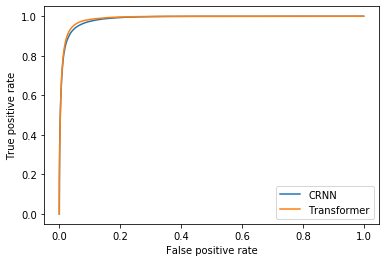

In [9]:
from sklearn.metrics import roc_curve

fpr1, tpr1, _ = roc_curve(y1_true, y1_pred)
fpr2, tpr2, _ = roc_curve(y2_true, y2_pred)
plt.figure()
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(['CRNN', 'Transformer'])

In [17]:
from sklearn.metrics import roc_auc_score

# roc_auc1 = roc_auc_score(true_vals1.reshape(-1,128), pred_vals1.reshape(-1,128))
# roc_auc2 = roc_auc_score(true_vals2.reshape(-1,128), pred_vals2.reshape(-1,128))
roc_auc1 = roc_auc_score(y1_true, y1_pred)
roc_auc2 = roc_auc_score(y2_true, y2_pred)
print(roc_auc1)
print(roc_auc2)

0.9866271744429467
0.9887845612943539


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


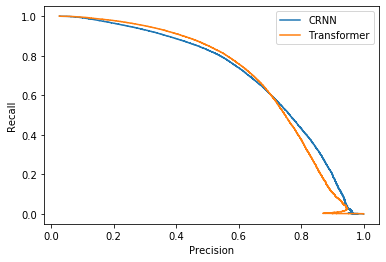

In [19]:
from sklearn.metrics import precision_recall_curve

precision1, recall1, _ = precision_recall_curve(y1_true, y1_pred)
precision2, recall2, _ = precision_recall_curve(y2_true, y2_pred)
plt.figure()
plt.plot(precision1, recall1)
plt.plot(precision2, recall2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(['CRNN', 'Transformer'])